# General DA fittings and Fokker-Planck comparisons


### If we are in the SWAN notebook system, you need to execute this!

In [ ]:
cd /eos/project/d/da-and-diffusion-studies/DA_Studies/Simulations/Models/da_sixtrack

In [ ]:
# For having no warnings in the visualization (USE ONLY IF YOU ARE NOT A DEVELOPER!)
import warnings
warnings.filterwarnings('ignore')

## Imports

In [1]:
%matplotlib notebook

In [2]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from scipy.special import erf
import pickle
import itertools
from scipy.optimize import curve_fit

from numba import njit, prange

# Personal libraries
#import sixtrackwrap_light as sx
import sixtrackwrap_light as sx

from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from math import gcd

import pandas as pd

from scipy.special import lambertw


matplotlib.rcParams['figure.figsize'] = [16, 12]

## Load data and setup original DA

In [3]:
savepath = "data/"
engine = sx.radial_scanner.load_values(savepath + "big_scan.pkl")

min_turns = engine.min_time
max_turns = engine.max_time
n_turn_samples = 500

turn_sampling = np.linspace(min_turns, max_turns, n_turn_samples, dtype=np.int_)[::-1]

d_r = engine.dr
starting_step = engine.starting_step

# BASELINE COMPUTING
baseline_samples = 33
baseline_total_samples = baseline_samples ** 3

In [4]:
alpha_preliminary_values = np.linspace(-1.0, 1.0, baseline_samples)
alpha_values = np.arccos(alpha_preliminary_values) / 2
theta1_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)
theta2_values = np.linspace(0.0, np.pi * 2.0, baseline_samples, endpoint=False)

d_preliminar_alpha = alpha_preliminary_values[1] - alpha_preliminary_values[0]
d_theta1 = theta1_values[1] - theta1_values[0]
d_theta2 = theta2_values[1] - theta2_values[0]

alpha_mesh, theta1_mesh, theta2_mesh = np.meshgrid(alpha_values, theta1_values, theta2_values, indexing='ij')

alpha_flat = alpha_mesh.flatten()
theta1_flat = theta1_mesh.flatten()
theta2_flat = theta2_mesh.flatten()

In [5]:
radiuses = engine.extract_DA(turn_sampling)
radiuses = radiuses.reshape((baseline_samples, baseline_samples, baseline_samples, len(turn_sampling)))

In [6]:
DA = []

mod_radiuses = radiuses.copy()
mod_radiuses = np.power(radiuses, 4)
mod_radiuses1 = integrate.simps(mod_radiuses, x=theta1_values, axis=1)
mod_radiuses2 = integrate.simps(mod_radiuses1, x=theta2_values, axis=1)
mod_radiuses3 = integrate.simps(mod_radiuses2, x=alpha_preliminary_values, axis=0)

for i in range(len(turn_sampling)):
    DA.append(
        np.power(
            mod_radiuses3[i] / (2 * theta1_values[-1] * theta2_values[-1]),
            1/4
        )
    )

DA = np.asarray(DA)

In [7]:
axis_sampling = np.concatenate((turn_sampling,[0.0]))

## Prepare inverse functions for obtaining DA from loss values

In [8]:
from pynverse import inversefunc

# Uniform 4D distribution

@njit
def uniform_loss(DA, DA0):
    return (DA ** 4 / DA0 ** 4)

@njit
def DA_from_unifom_loss(loss, DA0):
    return np.power((loss * DA0 ** 4), 1/4)

# Symmetric 4D gaussian

@njit
def symmetric_gaussian_loss(DA, sigma, DA0):
    baseline = - np.exp(- 0.5 * (DA0 / sigma) ** 2) * (DA0 ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
    return (- np.exp(- 0.5 * (DA / sigma) ** 2) * (DA ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2) / baseline


def DA_from_symmetric_gaussian_loss(loss, sigma, DA0):
    func = inversefunc(
        lambda x: symmetric_gaussian_loss(x, sigma, DA0),
        domain=0.0,
        open_domain=[False, True]
    )
    return func(loss)
    

## Define Fitting Models!

### Model 2

$$D(N) = \rho_\ast \left(\frac{\kappa}{2e}\right)^\kappa \frac{1}{\ln^\kappa\frac{N}{N_0}}$$


In [9]:
@njit
def model_2(x, rho, n0, k):
    return rho * np.power(k / (2 * np.exp(1)), k) / (np.power(np.log(x / n0), k))


def explore_k_model_2(turns, da, k_min, k_max, n_samples):
    ks = np.linspace(k_min, k_max, n_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a, b : model_2(x, a, b, k),
            turns,
            da,
            bounds=([0, 0.00001],[np.inf, turns[-1]-0.0001])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(np.sum(np.power(DA - model_2(turn_sampling, par[0], par[1], k), 2)[:]))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

### Model 4

$$D(N)=\rho_{*} \times \frac{1}{\left[-2 \mathrm{e} \lambda \mathcal{W}_{-1}\left(-\frac{1}{2 \mathrm{e} \lambda}\left(\frac{\rho_{\ast}}{6}\right)^{1 / \kappa}\left(\frac{8}{7} N\right)^{-1 /(\lambda \kappa)}\right)\right]^{\kappa}}
$$

(with $\lambda=0.5$)

In [10]:
def model_4(x, rho, k):
    lamb = 0.5
    return np.real(
        rho
        / np.power(-2 * np.exp(1) * lamb * lambertw(- (1 / (2 * np.exp(1) * lamb)) * np.power(rho / 6, 1 / k) * np.power((8/7) * x, -1 / (lamb * k)), -1), k)
    )

def explore_k_model_4(turns, da, k_min, k_max, n_samples):
    ks = np.linspace(k_min, k_max, n_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a : model_4(x, a, k),
            turns,
            da,
            bounds=([0.1],[np.inf])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(np.sum(np.power(DA - model_4(turn_sampling, par[0], k), 2)[:]))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

## Visualize original DA value from data

Text(0, 0.5, '$DA(N)$')

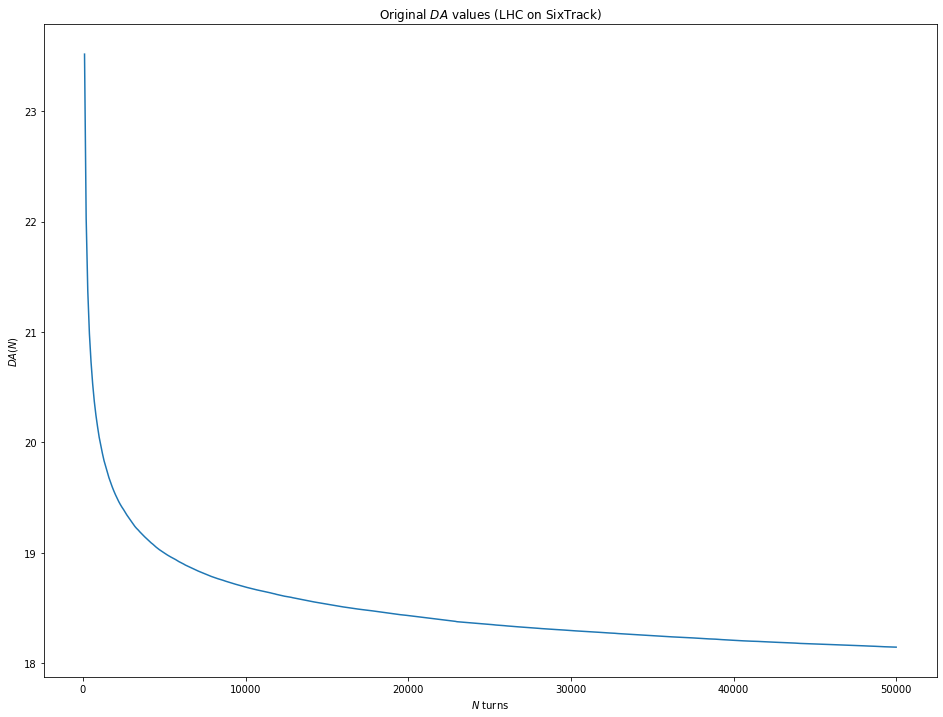

In [11]:
fig1, ax1 = plt.subplots()
ax1.plot(turn_sampling, DA)
ax1.set_title("Original $DA$ values (LHC on SixTrack)")
ax1.set_xlabel("$N$ turns")
ax1.set_ylabel("$DA(N)$")

## Setup Dataframe for storing the fitting data properly!

In [12]:
labels = (
    ("type", ""),
    ("sigma", ""),
    ("Model 2", "k"),
    ("Model 2", "k err"),
    ("Model 2", "rho"),
    ("Model 2", "rho err"),
    ("Model 2", "N0"),
    ("Model 2", "N0 err"),
    ("Model 4", "k"),
    ("Model 4", "k err"),
    ("Model 4", "rho"),
    ("Model 4", "rho err"),
    ("Model 4", "lambda")
)

fitting_data = pd.DataFrame(columns=pd.MultiIndex.from_tuples(labels))

## How is the error on the DA loss computed right now?

1. Consider all the radiuses sampled.
2. Compute the DA value.
3. For every radius sampled, compute the difference from the DA value.
4. The absolute value of the average of all these differences is considered as error.

(I tried using the Standard Deviation of the radiuses distribution, but it ended up being 10% of the DA itself, so we "need" somehow a smaller error estimation)
## Loss and Fits -- Uniform Beam Distribution
### Loss comparison

In [13]:
# Set DA0 cutting point
DA0 = 26.0

# Assign uniform weights to engine and compute loss
engine.assign_weights(
    sx.assign_uniform_distribution()
)
real_values = engine.compute_loss(turn_sampling, DA0)

# Compute DA-based loss
values = uniform_loss(DA, DA0)
values = np.concatenate((values, [1.0]))

# Error computing
values1 = uniform_loss(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), DA0)
values1 = np.concatenate((values1, [1.0]))

values2 = uniform_loss(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), DA0)
values2 = np.concatenate((values2, [1.0]))

#### Visualize Loss comparison

Text(0.5, 1.0, 'Uniform beam (Cutting Point at $DA=26.0$)')

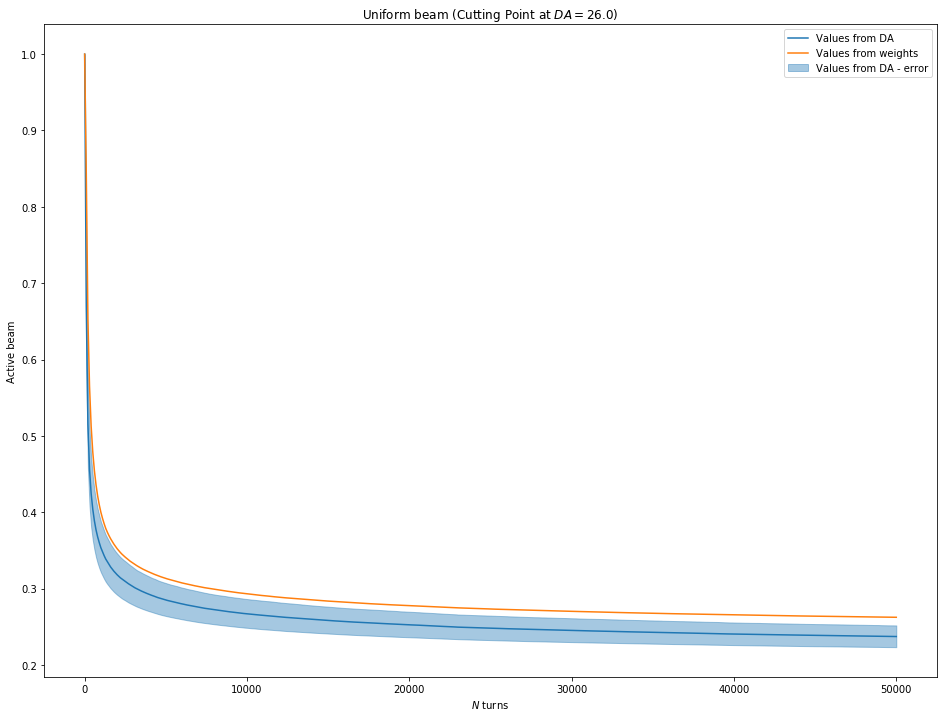

In [14]:
fig2, ax2 = plt.subplots()
ax2.plot(axis_sampling, values, label="Values from DA")
ax2.fill_between(axis_sampling, values1, values2, label="Values from DA - error", color="C0", alpha=0.4)
ax2.plot(axis_sampling, real_values, label="Values from weights")
ax2.legend()
ax2.set_xlabel("$N$ turns")
ax2.set_ylabel("Active beam")
ax2.set_title("Uniform beam (Cutting Point at $DA=26.0$)")

### Get DA from loss

In [15]:
DA_from_loss = DA_from_unifom_loss(real_values, DA0)

#### Visualize difference

Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss')

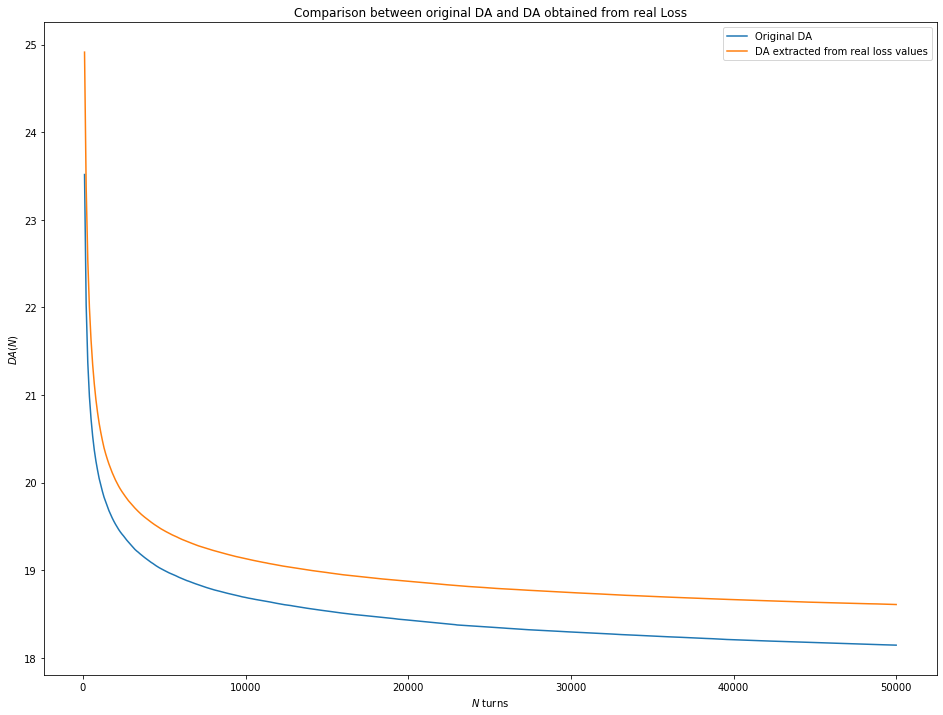

In [16]:
fig3, ax3 = plt.subplots()
ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss")

### Compare fitting values with Model 2

In [17]:
k_min = 0.01
k_max = 1
samples = 2000

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_2(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_2(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_k_2 = ks[np.argmin(real_errs)]
real_selected_pars_2 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_2 = real_co_pars[np.argmin(real_errs)]

loss_selected_k_2 = ks[np.argmin(loss_errs)]
loss_selected_pars_2 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_2 = loss_co_pars[np.argmin(loss_errs)]

100%|██████████| 2000/2000 [00:40<00:00, 49.02it/s]


In [18]:
print("REAL:", "$\\kappa:$", real_selected_k_2, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_2)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_2, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_2)

REAL: $\kappa:$ 0.12044022011005502 , $\rho_\ast$ and $N_0$ [36.24834656 46.24748528]
FROM LOSS: $\kappa:$ 0.11598299149574788 , $\rho_\ast$ and $N_0$ [36.15994349 63.14581688]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss, with Model 2 Fits')

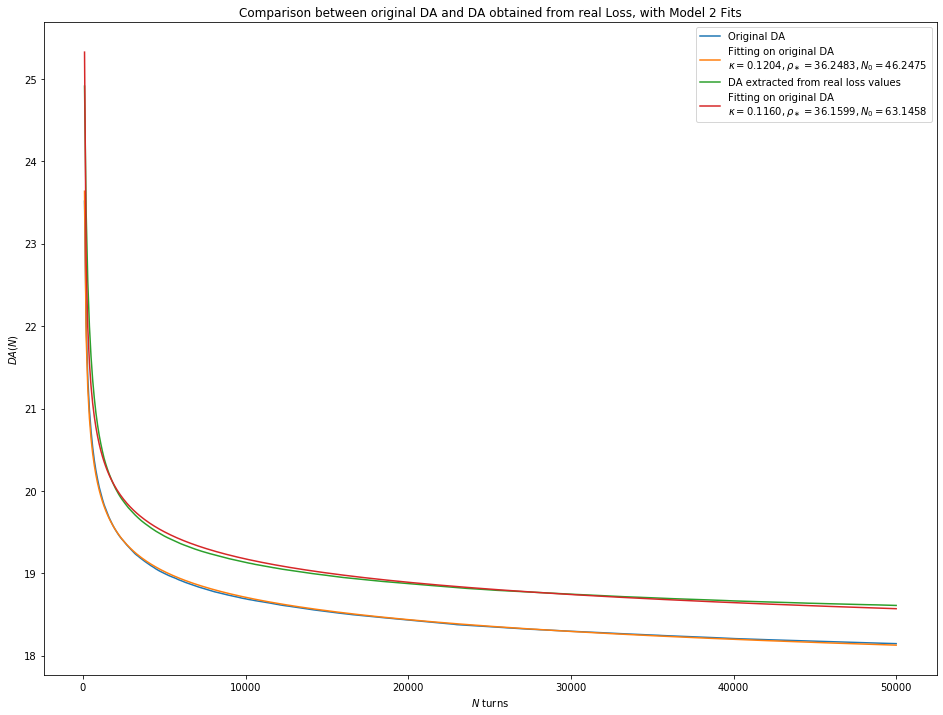

In [19]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_2(turn_sampling, real_selected_pars_2[0], real_selected_pars_2[1], real_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(real_selected_k_2, real_selected_pars_2[0], real_selected_pars_2[1] ))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_2(turn_sampling, loss_selected_pars_2[0], loss_selected_pars_2[1], loss_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(loss_selected_k_2, loss_selected_pars_2[0], loss_selected_pars_2[1] ))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss, with Model 2 Fits")

### Compare fitting values with Model 4

In [20]:
k_min = 0.05
k_max = 1
samples = 2000

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_4(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_4(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_k_4 = ks[np.argmin(real_errs)]
real_selected_pars_4 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_4 = real_co_pars[np.argmin(real_errs)]

loss_selected_k_4 = ks[np.argmin(loss_errs)]
loss_selected_pars_4 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_4 = loss_co_pars[np.argmin(loss_errs)]

100%|██████████| 2000/2000 [00:18<00:00, 106.09it/s]


In [21]:
print("REAL:", "$\\kappa:$", real_selected_k_4, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_4)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_4, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_4)

REAL: $\kappa:$ 0.21918459229614806 , $\rho_\ast$ and $N_0$ [61.0427413]
FROM LOSS: $\kappa:$ 0.21870935467733865 , $\rho_\ast$ and $N_0$ [62.42061348]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss, with Model 4 Fits $(\\lambda=0.5)$')

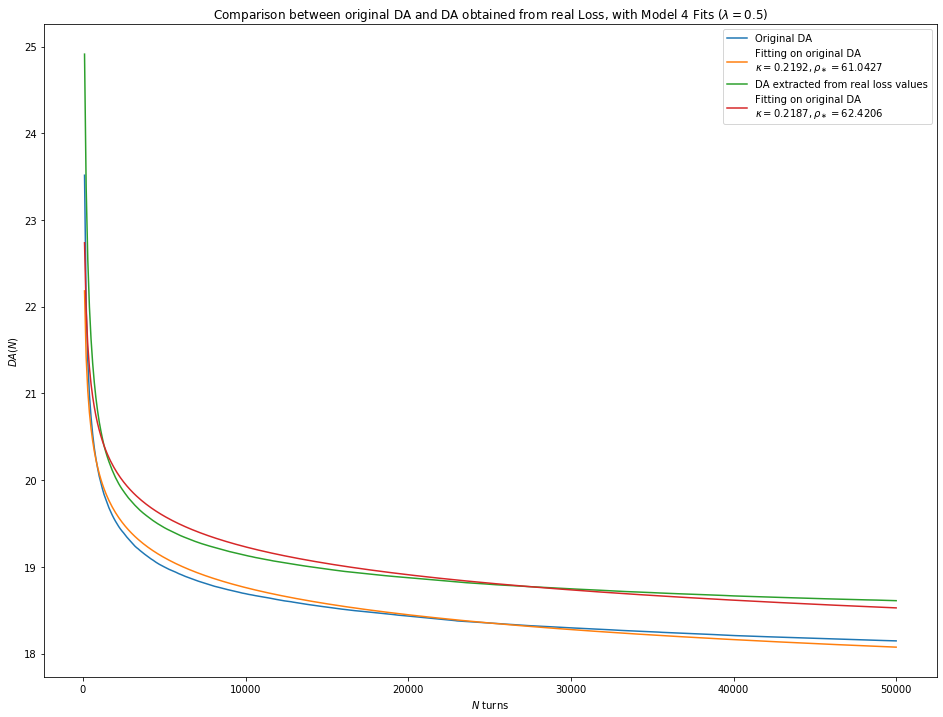

In [22]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_4(turn_sampling, real_selected_pars_4[0], real_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(real_selected_k_4, real_selected_pars_4[0]))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_4(turn_sampling, loss_selected_pars_4[0], loss_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(loss_selected_k_4, loss_selected_pars_4[0]))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss, with Model 4 Fits $(\\lambda=0.5)$")

### Save data in the dataframe

In [23]:
fitting_data.loc[len(fitting_data)] = [
     "real",
     np.nan,
     real_selected_k_2,
     ks[1] - ks[0],
     real_selected_pars_2[0],
     np.sqrt(real_selected_co_pars_2[0, 0]), 
     real_selected_pars_2[1], 
     np.sqrt(real_selected_co_pars_2[1, 1]), 
     real_selected_k_4, 
     ks[1] - ks[0], 
     real_selected_pars_4[0], 
     np.sqrt(real_selected_co_pars_4[0, 0]),
     1/2
]


fitting_data.loc[len(fitting_data)] = [
    "uniform",
     np.nan,
     loss_selected_k_2,
     ks[1] - ks[0],
     loss_selected_pars_2[0],
     np.sqrt(loss_selected_co_pars_2[0, 0]),
     loss_selected_pars_2[1],
     np.sqrt(loss_selected_co_pars_2[1, 1]),
     loss_selected_k_4,
     ks[1] - ks[0],
     loss_selected_pars_4[0],
     np.sqrt(loss_selected_co_pars_4[0, 0]),
     1/2
]

## Loss and Fits -- Symmetric Gaussian Beam Distribution
### Choose your Sigma!

In [24]:
sigma = 15.0

### Loss comparison

In [25]:
# Set DA0 cutting point
DA0 = 26.0

# Assign uniform weights to engine and compute loss
engine.assign_weights(
    sx.assign_symmetric_gaussian(sigma)
)
real_values = engine.compute_loss(turn_sampling, DA0)

# Compute DA-based loss
values = symmetric_gaussian_loss(DA, sigma, DA0)
values = np.concatenate((values, [1.0]))

# Error computing
values1 = symmetric_gaussian_loss(DA - np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), sigma, DA0)
values1 = np.concatenate((values1, [1.0]))

values2 = symmetric_gaussian_loss(DA + np.absolute(np.mean(radiuses - DA, axis=(0,1,2))), sigma, DA0)
values2 = np.concatenate((values2, [1.0]))

#### Visualize Loss comparison

Text(0.5, 1.0, 'Symmetric Gaussian beam ($\\sigma=15.0$, Cutting Point at $DA=26.0$)')

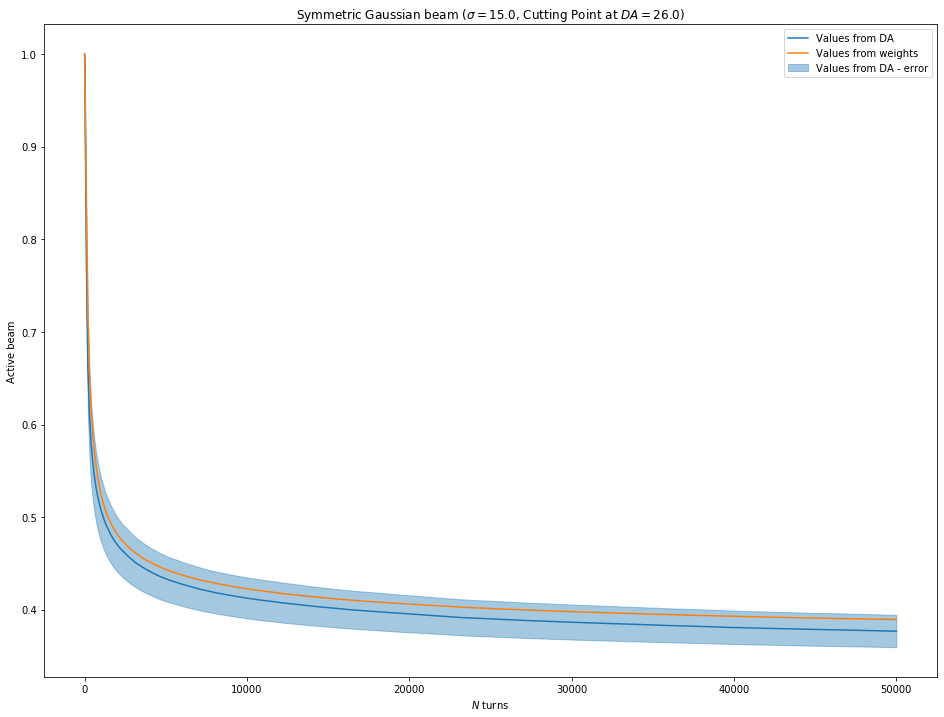

In [26]:
fig2, ax2 = plt.subplots()
ax2.plot(axis_sampling, values, label="Values from DA")
ax2.fill_between(axis_sampling, values1, values2, label="Values from DA - error", color="C0", alpha=0.4)
ax2.plot(axis_sampling, real_values, label="Values from weights")
ax2.legend()
ax2.set_xlabel("$N$ turns")
ax2.set_ylabel("Active beam")
ax2.set_title("Symmetric Gaussian beam ($\\sigma={}$, Cutting Point at $DA=26.0$)".format(sigma))

### Get DA from loss

In [27]:
DA_from_loss = DA_from_symmetric_gaussian_loss(real_values, sigma, DA0)

#### Visualize difference

Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss')

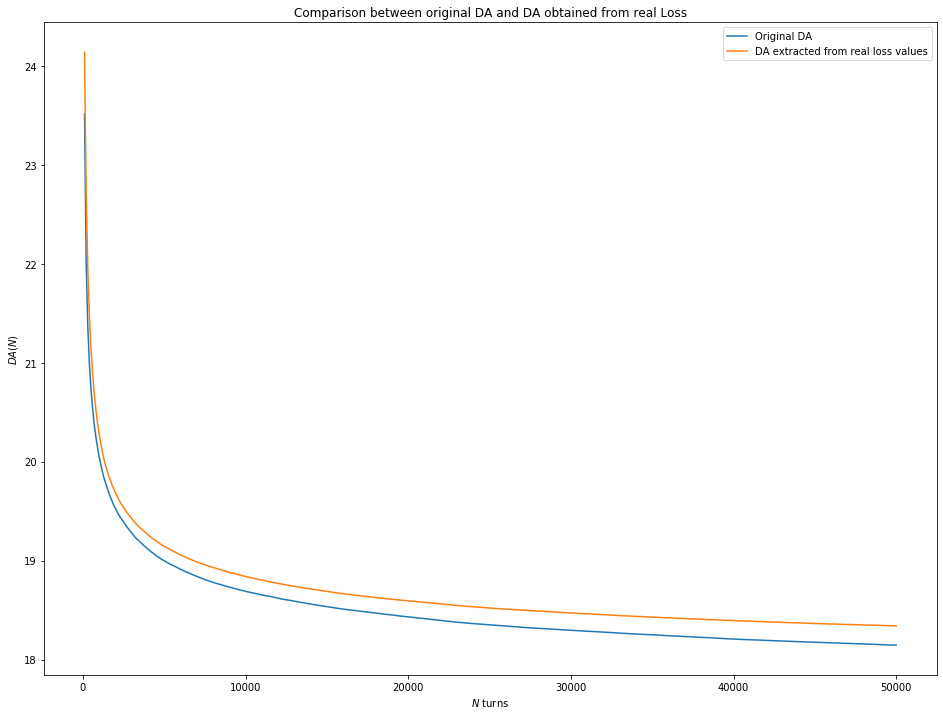

In [28]:
fig3, ax3 = plt.subplots()
ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss")

### Compare fitting values with Model 2

In [29]:
k_min = 0.01
k_max = 1
samples = 2000

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_2(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_2(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_k_2 = ks[np.argmin(real_errs)]
real_selected_pars_2 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_2 = real_co_pars[np.argmin(real_errs)]

loss_selected_k_2 = ks[np.argmin(loss_errs)]
loss_selected_pars_2 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_2 = loss_co_pars[np.argmin(loss_errs)]

100%|██████████| 2000/2000 [00:41<00:00, 48.26it/s]


In [30]:
print("REAL:", "$\\kappa:$", real_selected_k_2, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_2)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_2, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_2)

REAL: $\kappa:$ 0.12044022011005502 , $\rho_\ast$ and $N_0$ [36.24834656 46.24748528]
FROM LOSS: $\kappa:$ 0.11994497248624313 , $\rho_\ast$ and $N_0$ [36.39737958 53.14201819]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss, with Model 2 Fits')

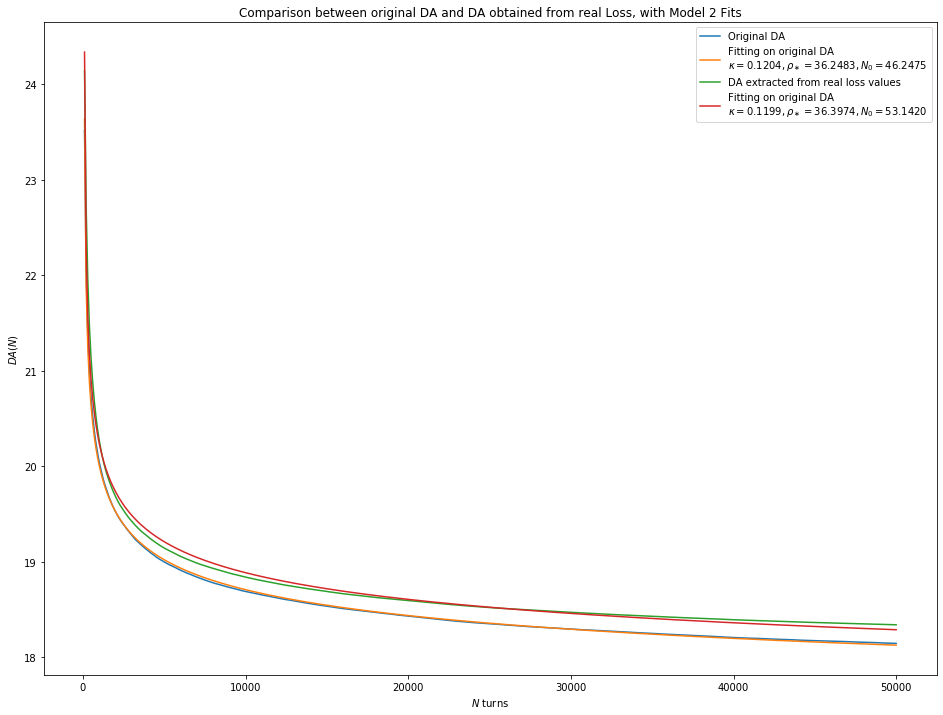

In [31]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_2(turn_sampling, real_selected_pars_2[0], real_selected_pars_2[1], real_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(real_selected_k_2, real_selected_pars_2[0], real_selected_pars_2[1] ))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_2(turn_sampling, loss_selected_pars_2[0], loss_selected_pars_2[1], loss_selected_k_2), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}, N_0={:.4f}$".format(loss_selected_k_2, loss_selected_pars_2[0], loss_selected_pars_2[1] ))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss, with Model 2 Fits")

### Compare fitting values with Model 4

In [32]:
k_min = 0.05
k_max = 1
samples = 2000

ks = np.linspace(k_min, k_max, samples)

real_pars, real_errs, real_co_pars = explore_k_model_4(turn_sampling, DA, k_min, k_max, samples)
loss_pars, loss_errs, loss_co_pars = explore_k_model_4(axis_sampling[:-1], DA_from_loss[:-1], k_min, k_max, samples)

real_selected_k_4 = ks[np.argmin(real_errs)]
real_selected_pars_4 = real_pars[np.argmin(real_errs)]
real_selected_co_pars_4 = real_co_pars[np.argmin(real_errs)]

loss_selected_k_4 = ks[np.argmin(loss_errs)]
loss_selected_pars_4 = loss_pars[np.argmin(loss_errs)]
loss_selected_co_pars_4 = loss_co_pars[np.argmin(loss_errs)]

100%|██████████| 2000/2000 [00:18<00:00, 105.64it/s]


In [33]:
print("REAL:", "$\\kappa:$", real_selected_k_4, ", $\\rho_\\ast$ and $N_0$", real_selected_pars_4)
print("FROM LOSS:", "$\\kappa:$", loss_selected_k_4, ", $\\rho_\\ast$ and $N_0$", loss_selected_pars_4)

REAL: $\kappa:$ 0.21918459229614806 , $\rho_\ast$ and $N_0$ [61.0427413]
FROM LOSS: $\kappa:$ 0.21870935467733865 , $\rho_\ast$ and $N_0$ [61.48242142]


Text(0.5, 1.0, 'Comparison between original DA and DA obtained from real Loss, with Model 4 Fits $(\\lambda=0.5)$')

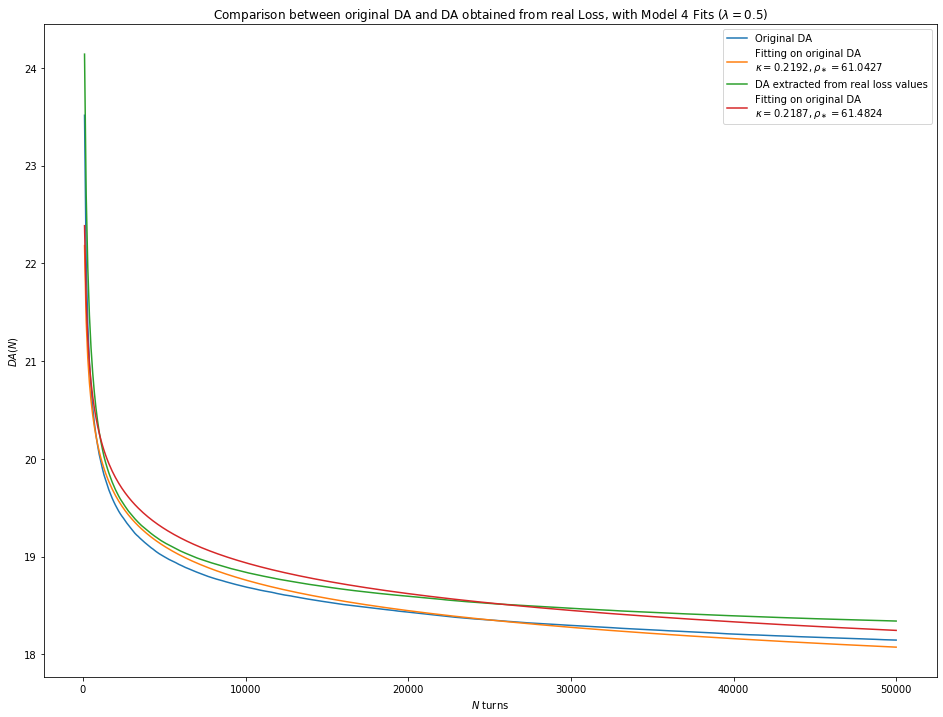

In [34]:
fig3, ax3 = plt.subplots()

ax3.plot(turn_sampling, DA, label="Original DA")
ax3.plot(turn_sampling, model_4(turn_sampling, real_selected_pars_4[0], real_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(real_selected_k_4, real_selected_pars_4[0]))

ax3.plot(axis_sampling[:-1], DA_from_loss[:-1], label="DA extracted from real loss values")
ax3.plot(turn_sampling, model_4(turn_sampling, loss_selected_pars_4[0], loss_selected_k_4), label="Fitting on original DA\n$\\kappa = {:.4f},\\rho_\\ast = {:.4f}$".format(loss_selected_k_4, loss_selected_pars_4[0]))

ax3.legend()
ax3.set_xlabel("$N$ turns")
ax3.set_ylabel("$DA(N)$")
ax3.set_title("Comparison between original DA and DA obtained from real Loss, with Model 4 Fits $(\\lambda=0.5)$")

### Save data in the dataframe

In [35]:
fitting_data.loc[len(fitting_data)] = [
    "gaussian",
     sigma,
     loss_selected_k_2,
     ks[1] - ks[0],
     loss_selected_pars_2[0],
     np.sqrt(loss_selected_co_pars_2[0, 0]),
     loss_selected_pars_2[1],
     np.sqrt(loss_selected_co_pars_2[1, 1]),
     loss_selected_k_4,
     ks[1] - ks[0],
     loss_selected_pars_4[0],
     np.sqrt(loss_selected_co_pars_4[0, 0]),
     1/2
]


## Display general dataframe with fitting data

In [36]:
fitting_data

type sigma   Model 2                                            \
                          k     k err        rho   rho err         N0   
0      real   NaN  0.120440  0.000475  36.248347  0.003771  46.247485   
1   uniform   NaN  0.115983  0.000475  36.159943  0.008910  63.145817   
2  gaussian  15.0  0.119945  0.000475  36.397380  0.009060  53.142018   

              Model 4                                        
     N0 err         k     k err        rho   rho err lambda  
0  0.202349  0.219185  0.000475  61.042741  0.012779    0.5  
1  0.567224  0.218709  0.000475  62.420613  0.021589    0.5  
2  0.524095  0.218709  0.000475  61.482421  0.018352    0.5